In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

Optimal Partial Transport of Discrete Distributions
------------------------------------------

We consider two dicretes distributions
$$ \al = \sum_{i=1}^n a_i \de_{x_i} \qandq 
   \be = \sum_{j=1}^m b_j \de_{y_j}. $$
   
where $n,m$ are the number of points, $\de_x$ is the Dirac at
location $x \in \RR^d$, and $(x_i)_i, (y_j)_j$ are the positions of the diracs in $\RR^d$. 

Dimensions $(n,m)$ of the coulds.

In [39]:
n = 60
m = 80

Generate the point clouds $X=(x_i)_i$ and $Y=(y_j)_j$.

In [40]:
gauss = lambda q,a,c: a*np.random.randn(2, q) + np.transpose(np.tile(c, (q,1)))
X = np.random.randn(2,n)*.3
Y = np.hstack((gauss(int(m/2),.5,[0,1.6]),np.hstack((gauss(int(m/4),.3,[-1,-1]),gauss(int(m/4),.3,[1,-1])))))

Generate the weights $a,b$.

In [41]:
normalize = lambda a: a/np.sum(a)
a = normalize(np.random.rand(n, 1))
b = normalize(np.random.rand(m, 1))

Helper function for display of clouds.

In [42]:
myplot = lambda x,y,ms,col: plt.scatter(x,y, s=ms*20, edgecolors="k", c=col, linewidths=2)

Display the point clouds.
The size of each dot is proportional to its probability density weight.

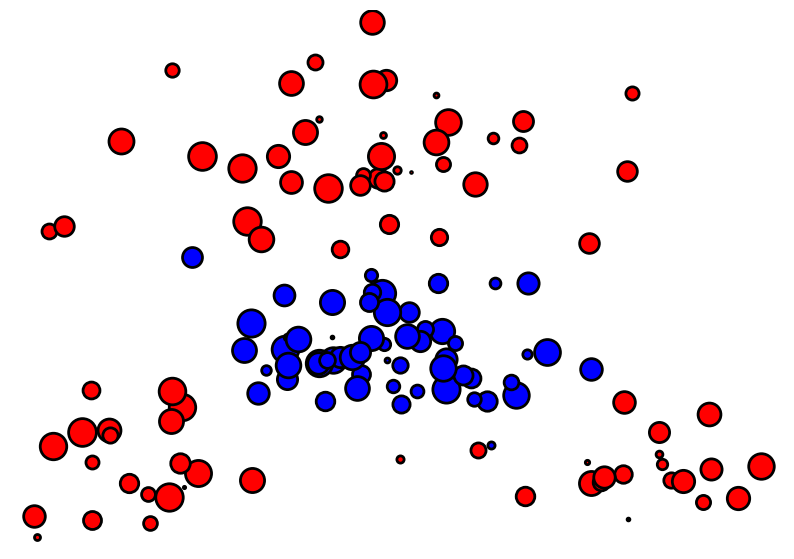

In [43]:
plt.figure(figsize = (10,7))
plt.axis("off")
for i in range(len(a)):
    myplot(X[0,i], X[1,i], a[i]*len(a)*10, 'b')
for j in range(len(b)):
    myplot(Y[0,j], Y[1,j], b[j]*len(b)*10, 'r')
plt.xlim(np.min(Y[0,:])-.1,np.max(Y[0,:])+.1)
plt.ylim(np.min(Y[1,:])-.1,np.max(Y[1,:])+.1)
plt.show()

Compute the cost matrix $C_{i,j} := \norm{x_i-x_j}^2$.

In [44]:
def distmat(x,y):
    return np.sum(x**2,0)[:,None] + np.sum(y**2,0)[None,:] - 2*x.transpose().dot(y)
C = distmat(X,Y)

Define the optimiztion variable $P$.

In [45]:
P = cp.Variable((n+1,m+1))
Cp = np.zeros((n+1,m+1))
Cp[0:n,0:m] = C
ap = np.zeros((n+1,1))
bp = np.zeros((m+1,1))
M = 0.5 # mass to be transported
ap[:n]=a
bp[:m]=b
ap[n,0] = 1-M
bp[m,0] = 1-M

Define the set of discrete couplings between $\al$ and $\be$
$$ U(a,b) := \enscond{ P \in \RR_+^{n \times m} }{
     \forall i, \sum_j P_{i,j} = a_i, \:
     \forall j, \sum_i P_{i,j} = b_j }. $$

In [46]:
u = np.ones((m+1,1))
v = np.ones((n+1,1))
U = [0 <= P, cp.matmul(P,u)==ap, cp.matmul(P.T,v)==bp]

The Kantorovitch formulation of the optimal transport reads
$$ P^\star \in \uargmin{P \in U(a,b)} \sum_{i,j} P_{i,j} C_{i,j}.  $$
Solve it using CVXPY

In [47]:
objective = cp.Minimize( cp.sum(cp.multiply(P,Cp)) )
prob = cp.Problem(objective, U)
prob.solve(solver=cp.ECOS, abstol=1e-9, reltol=1e-9, feastol=1e-9)

0.28525017222539595

An optimal coupling $P^\star$ can be shown to be a sparse matrix
with less than $n+m-1$ non zero entries. An entry $P_{i,j}^\star \neq 0$
should be understood as a link between $x_{i}$
and $y_{j}$ where an amount of mass equal to $P_{i,j}^\star$ is transfered.

Check that the number of non-zero entries in $P^\star$ is $n+m-1$. Beware that we are using an interior point method here, so that entries of $P^\star$ are nevery exactly 0.

In [48]:
print("Number of non-zero: %d (n + m-1 = %d)" %(len(P.value[P.value>1e-5]), n + m-1))

Number of non-zero: 141 (n + m-1 = 139)


Display the solution coupling.

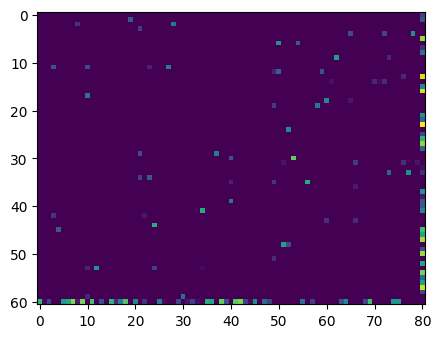

In [49]:
plt.figure(figsize = (5,5))
plt.imshow(P.value);

Display the connexion defined by the optimal coupling.

0.4999999999999885
0.008639578766688662 [0.01659087] [0.00863958] 0.3963339527327837
0.004740905479885193 [0.01712508] [0.00727227] 0.3857452577726952
0.012384174187648037 [0.01712508] [0.01238417] 0.33338738759590525
0.005060816356397452 [0.00506082] [0.01785127] 0.6746542210206419
0.007101460893132566 [0.02827612] [0.00891514] 0.6275280870067024
0.006293852021874674 [0.02827612] [0.00998238] 0.6113479915706319
0.01488080258171998 [0.02827612] [0.0148808] 0.5774098843217692
0.015574320303526972 [0.02482791] [0.02494515] 0.8866150214702573
0.009253593807045959 [0.02482791] [0.00925359] 0.49687124340660094
0.01689942228987156 [0.02028198] [0.01689942] 0.3692750618583376
0.0033825604898388715 [0.02028198] [0.01320369] 0.3498198956078453
0.007868592874983548 [0.03008731] [0.01248195] 0.9017642070169327
0.006663225239543005 [0.03008731] [0.02470428] 0.7992919177757254
0.0030219891405126897 [0.03008731] [0.01194283] 0.8559208486507721
0.012533507496757298 [0.03008731] [0.01253351] 0.7928582

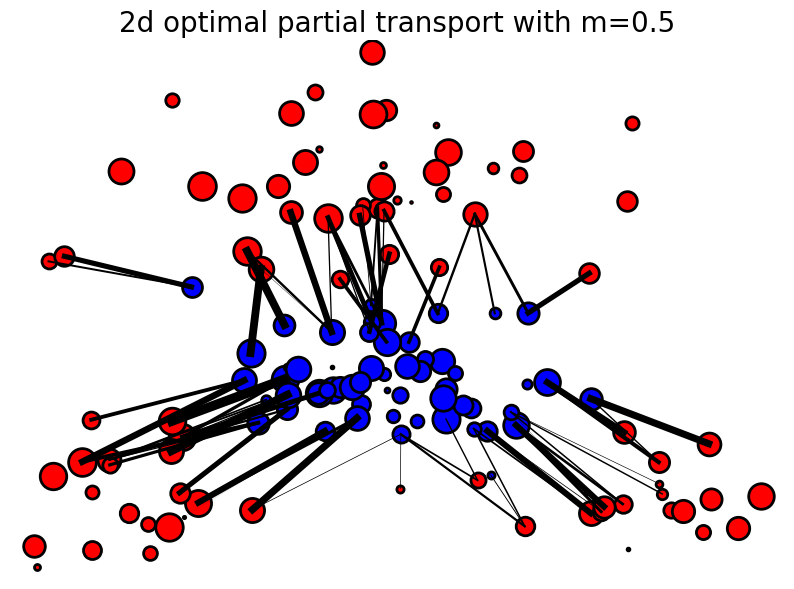

In [53]:
I,J = np.nonzero(P[:n,:m].value>1e-5)
print(np.sum(P[:n,:m].value))
plt.figure(figsize = (10,7))
plt.axis('off')
for k in range(len(I)):
    i, j = I[k],J[k]
    h = plt.plot(np.hstack((X[0,I[k]],Y[0,J[k]])),np.hstack(([X[1,I[k]], Y[1,J[k]]])),'k', lw = 300*P.value[I[k],J[k]])
    print(P.value[i,j], a[i], b[j], C[i,j])
for i in range(len(a)):
    myplot(X[0,i], X[1,i], a[i]*len(a)*10, 'b')
for j in range(len(b)):
    myplot(Y[0,j], Y[1,j], b[j]*len(b)*10, 'r')
plt.xlim(np.min(Y[0,:])-.1,np.max(Y[0,:])+.1)
plt.ylim(np.min(Y[1,:])-.1,np.max(Y[1,:])+.1)
plt.title("2d optimal partial transport with m=0.5",fontsize=20)
plt.show()

In [54]:
def solve_partial(C,a,b,M):
    n = a.shape[0]
    m = b.shape[0]
    P = cp.Variable((n+1,m+1))
    Cp = np.zeros((n+1,m+1))
    Cp[0:n,0:m] = C
    ap = np.zeros((n+1,1))
    bp = np.zeros((m+1,1))
    ap[:n]=a
    bp[:m]=b
    ap[n,0] = 1-M
    bp[m,0] = 1-M

    u = np.ones((m+1,1))
    v = np.ones((n+1,1))
    U = [0 <= P, cp.matmul(P,u)==ap, cp.matmul(P.T,v)==bp]
    objective = cp.Minimize( cp.sum(cp.multiply(P,Cp)) )
    prob = cp.Problem(objective, U)
    prob.solve(solver=cp.ECOS, abstol=1e-9, reltol=1e-9, feastol=1e-9)
    return P.value,prob.value

0.4999999999999885


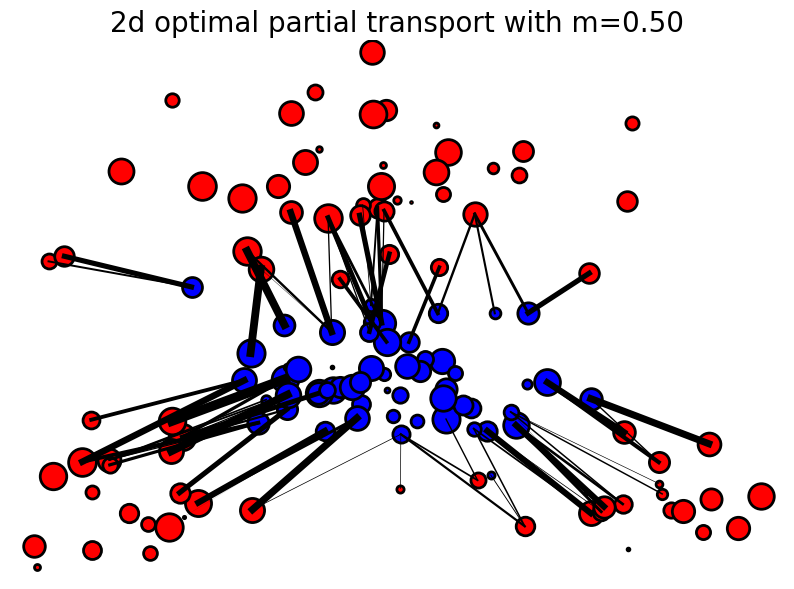

In [55]:
P, value = solve_partial(C,a,b,0.5)
I,J = np.nonzero(P[:n,:m]>1e-5)
print(np.sum(P[:n,:m]))
plt.figure(figsize = (10,7))
plt.axis('off')
for k in range(len(I)):
    i, j = I[k],J[k]
    h = plt.plot(np.hstack((X[0,I[k]],Y[0,J[k]])),np.hstack(([X[1,I[k]], Y[1,J[k]]])),'k', lw = 300*P[I[k],J[k]])
    #print(P.value[i,j], a[i], b[j], C[i,j])
for i in range(len(a)):
    myplot(X[0,i], X[1,i], a[i]*len(a)*10, 'b')
for j in range(len(b)):
    myplot(Y[0,j], Y[1,j], b[j]*len(b)*10, 'r')
plt.xlim(np.min(Y[0,:])-.1,np.max(Y[0,:])+.1)
plt.ylim(np.min(Y[1,:])-.1,np.max(Y[1,:])+.1)
plt.title(f"2d optimal partial transport with m={0.5:.2f}",fontsize=20)
plt.show()

Text(0.5, 1.0, 'Graph of $C(m)$')

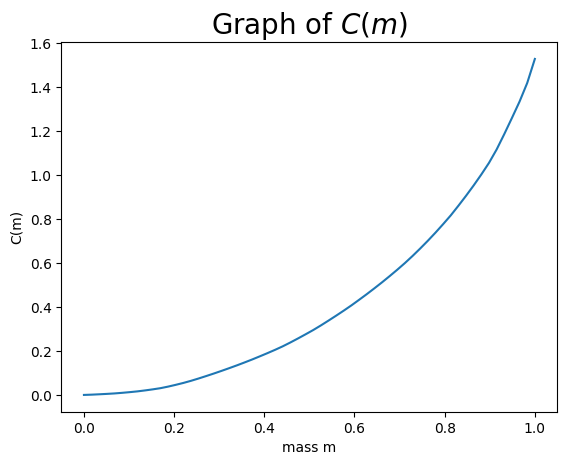

In [58]:

masses = np.linspace(0,1,60)
costs = []
for mass in masses:
    P, value = solve_partial(C,a,b,mass)
    costs.append(value)

plt.plot(masses,costs)
plt.xlabel("mass m")
plt.ylabel("C(m)")
plt.title("Graph of $C(m)$",fontsize = 20)

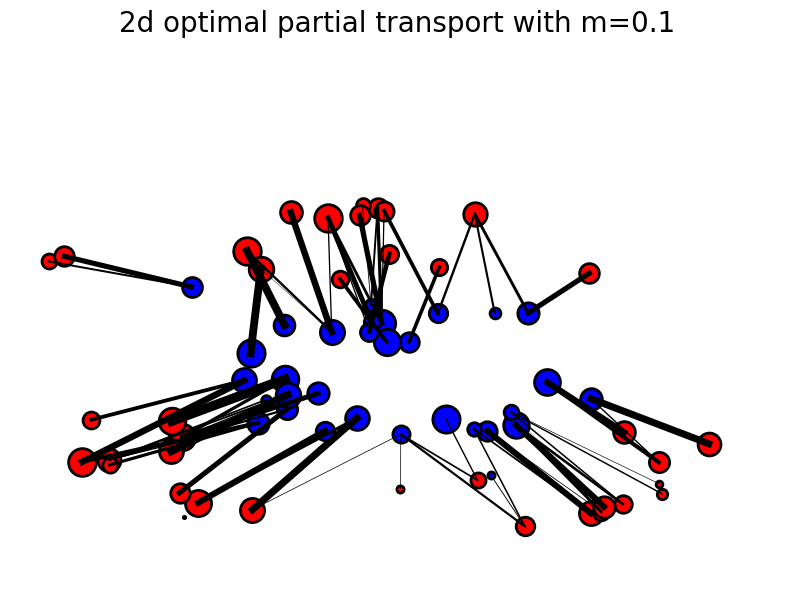

In [57]:
P, value = solve_partial(C,a,b,0.5)
I,J = np.nonzero(P[:n,:m]>1e-5)
plt.figure(figsize = (10,7))
plt.axis('off')
for k in range(len(I)):
    i, j = I[k],J[k]
    h = plt.plot(np.hstack((X[0,I[k]],Y[0,J[k]])),np.hstack(([X[1,I[k]], Y[1,J[k]]])),'k', lw = 300*P[I[k],J[k]])
    #print(P.value[i,j], a[i], b[j], C[i,j])
for i in range(len(a)):
    if P[i,:m].sum()>1e-5:
        myplot(X[0,i], X[1,i], a[i]*len(a)*10, 'b')
for j in range(len(b)):
    if P[:n,j].sum()>1e-5:
        myplot(Y[0,j], Y[1,j], b[j]*len(b)*10, 'r')
plt.xlim(np.min(Y[0,:])-.1,np.max(Y[0,:])+.1)
plt.ylim(np.min(Y[1,:])-.1,np.max(Y[1,:])+.1)
plt.title("2d optimal partial transport with m=0.1",fontsize=20)
plt.show()